importing IPython notebook from DX_screen_int

importing IPython notebook from Imports

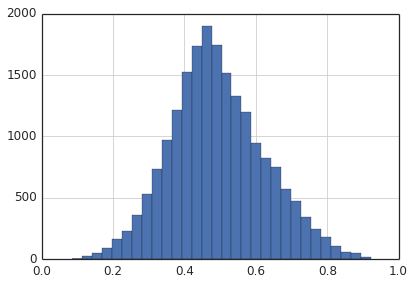

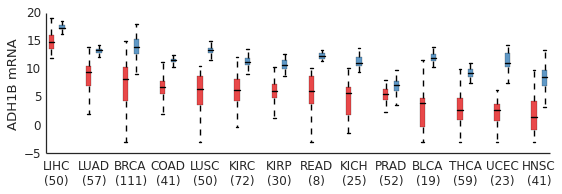

In [1]:
import NotebookImport
import DX_screen_int as DX

In [2]:
cd ../DX/Notebooks/

/cellar/users/agross/TCGA_Code/DX/Notebooks


In [3]:
from Imports import *
from Preprocessing.ClinicalData import *

importing IPython notebook from Preprocessing/ClinicalData

PCPG
UCS
MESO


In [4]:
cancers = codes.ix[matched_tn.columns.get_level_values(0)].unique()
pts = matched_tn.columns.get_level_values(0)
cancers_to_use = ti(codes.ix[pts].value_counts() > 15)

#df_inf = {c: infer_normal_knn(rna_df.ix[:, ti(codes == c)], r_curtoff=.3, k=5)
#          for c in cancers_to_use}
#tn_inf_c = pd.concat(df_inf.values(), axis=1)

In [5]:
f = DX.dx_rna.frac
#f = ((f -.5) / f.std())
f3 = f.round(1)
f4 = np.floor(DX.dx_rna.frac * 5)
f5 = f4[f4 != 2]
f5 = f[(f - .5).abs() > .15]
fm = f.ix[f5.index]
#fm = f

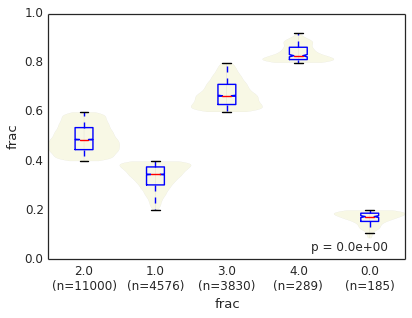

In [6]:
violin_plot_pandas(f4, f)

In [7]:
codes = DX.codes

In [8]:
store = pd.HDFStore('/data_ssd/RNASeq_2015_02_04.h5')

In [20]:
mm = DX.rna_df.xs('11',1,1).ix[:, codes.index].mean(1).ix[fm.index]
ss = DX.rna_df.xs('11',1,1).ix[:, codes.index].std(1).ix[fm.index]

In [21]:
%%time
rna_s = {}
for c in store.keys():
    if c in ['/matched_tn','/codes']:
        continue
    df = store[c].ix[fm.index]
    #most frequent tissue (tumor, normal, ect)
    tissue = pd.value_counts(df.columns.get_level_values(1)).index[0]
    #d2 = df.xs(tissue,1,1)
    #df = df.sub(d2.mean(1), axis=0).div(d2.std(1), axis=0)
    df = df.sub(mm, axis=0).div(ss, axis=0)
    rna_s[c] = df.corrwith(fm)
rna_s = pd.concat(rna_s)
rna_s.index = rna_s.index.droplevel(0)
rna_s = rna_s.groupby(level=[0,1]).first()
rp = rna_s.dropna()

CPU times: user 6.87 s, sys: 1.44 s, total: 8.31 s
Wall time: 6.63 s


In [22]:
#rp.to_csv('/cellar/users/agross/TCGA_Code/DX/rna_signature.csv')

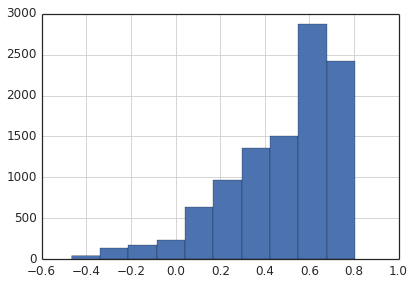

In [23]:
rp.hist()

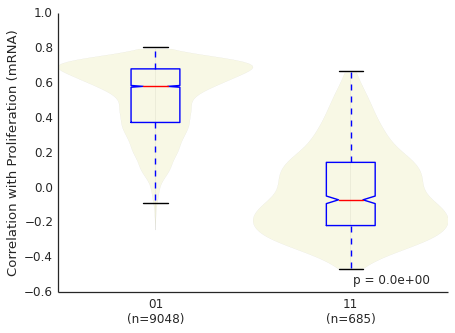

In [24]:
fig, ax = subplots(figsize=(7,5))
violin_plot_series(rp, ax=ax, order=['01','11'])
ax.set_ylabel('Correlation with Proliferation (mRNA)')
ax.set_xlabel('')
prettify_ax(ax)

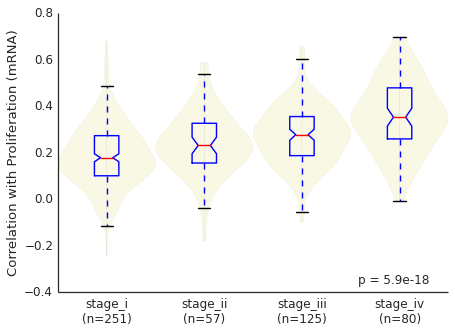

In [40]:
fig, ax = subplots(figsize=(7,5))
violin_plot_pandas(stage.ix[ti(codes=='KIRC')], rp[:,'01'], ax=ax, 
                   order=['stage_i','stage_ii','stage_iii','stage_iv'])
ax.set_ylabel('Correlation with Proliferation (mRNA)')
ax.set_xlabel('')
prettify_ax(ax)

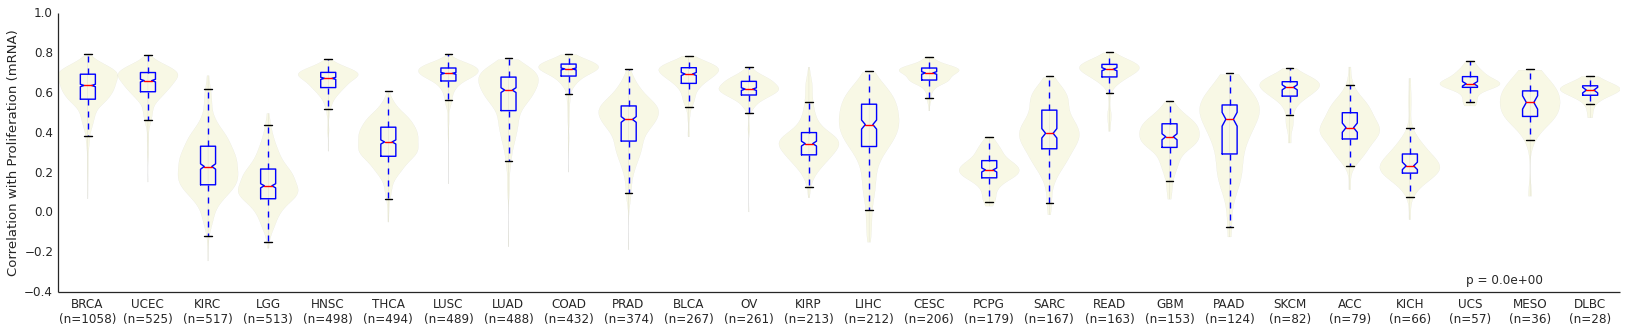

In [26]:
fig, ax = subplots(figsize=(28,5))
violin_plot_pandas(DX.codes, rp[:,'01'], ax=ax)
ax.set_xlabel('')
ax.set_ylabel('Correlation with Proliferation (mRNA)')
prettify_ax(ax)

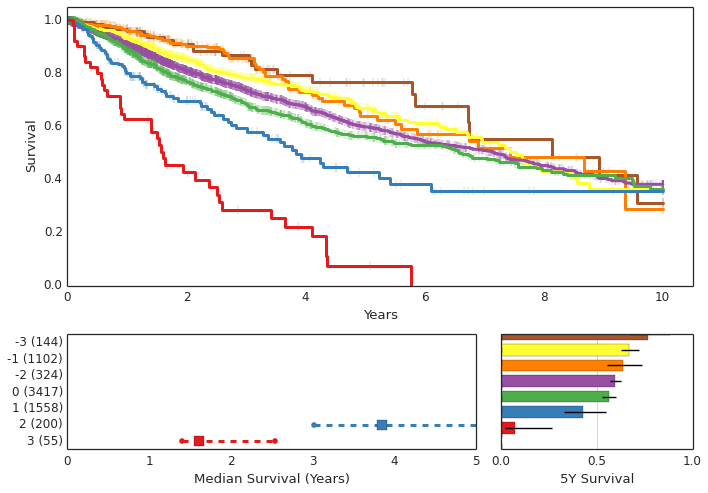

In [27]:
v = rp.ix[:, '01'].dropna()
v = v - DX.codes.map(v.groupby(DX.codes).median())
survival_and_stats(np.round((v - v.mean()) / v.std()).clip(-3,3), surv_10y,
                   figsize=(10,7))

In [28]:
v = rp.ix[:, '01'].dropna()
#v = v - DX.codes.map(v.groupby(DX.codes).median())
v.name = 'cc'
v = v.dropna()

In [29]:
codes = codes.groupby(level=0).first()
codes.name = 'codes'
v.name = 'v'

In [30]:
get_cox_ph_ms(surv_10y, v, [codes.ix[v.index].dropna(), stage], interactions=True)

LR                                                    2.22e-14
feature_p                                                  NaN
fmla         Surv(days, event) ~ codes + codes:feature + co...
hazzard                                                    NaN
dtype: object

In [31]:
get_cox_ph_ms(surv_10y, v, [codes, stage], interactions=False)

LR                                                1.09e-14
feature_p                                         5.98e-14
fmla         Surv(days, event) ~ feature + codes + stage\n
hazzard                                               7.83
dtype: object

In [32]:
from Figures.Survival import draw_survival_curves_mpl

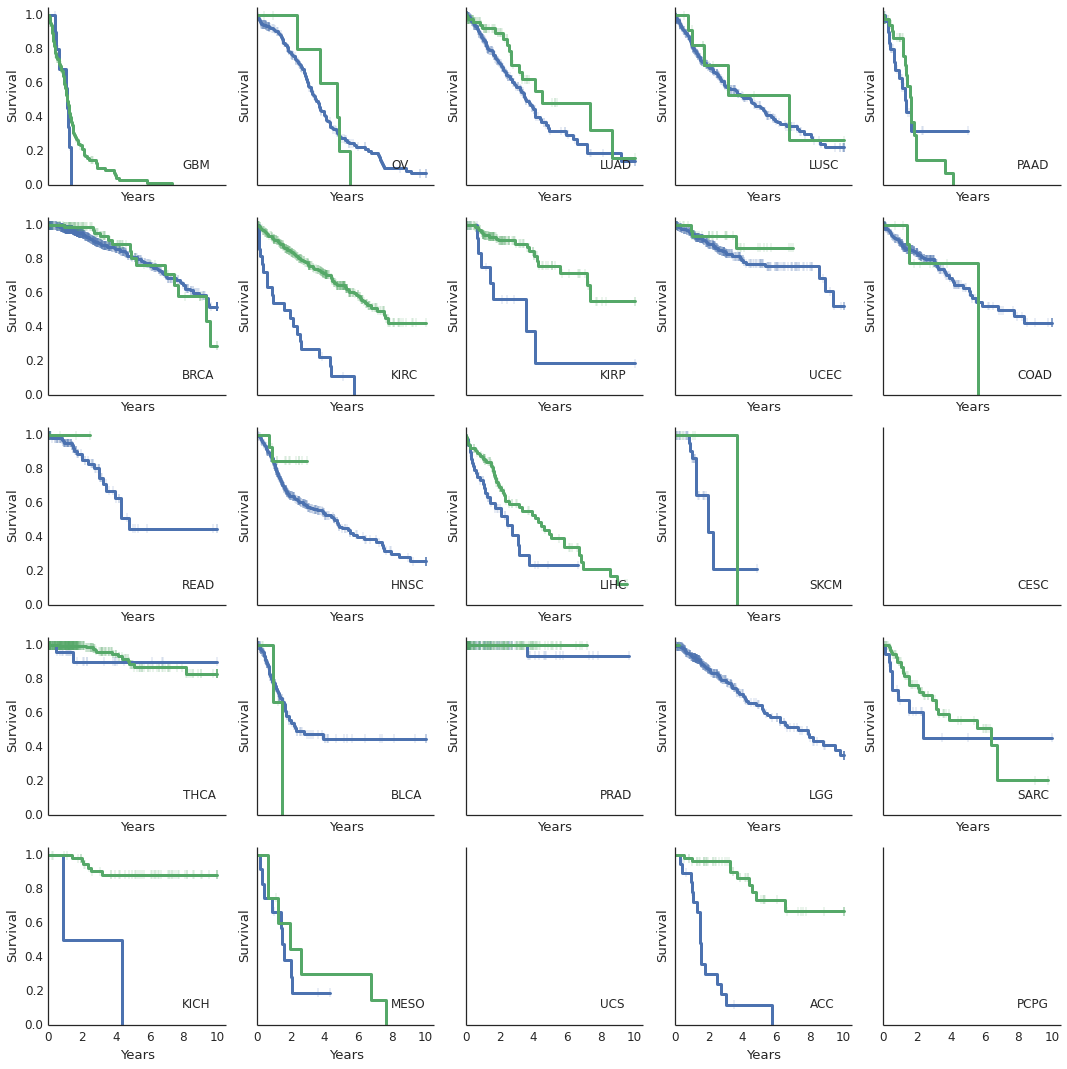

In [33]:
cc = codes.ix[v.index].dropna()
ss = surv_10y.unstack().index
cc = cc[cc.isin(ti(cc.value_counts()  > 30))]
fig, axs = subplots(5,5, figsize=(15,15), sharey=True, sharex=True)
axs = axs.flatten()
for i,c in enumerate(cc.unique()):
    ax = axs[i]
    ax.annotate(c, (8, .1))
    try:
        draw_survival_curve(v.ix[ss].ix[ti(cc==c)].dropna() < .5, surv_10y,
                            ax=ax)
        ax.legend_.set_visible(False)
    except:
        pass
fig.tight_layout()
DX.sns.despine(fig)

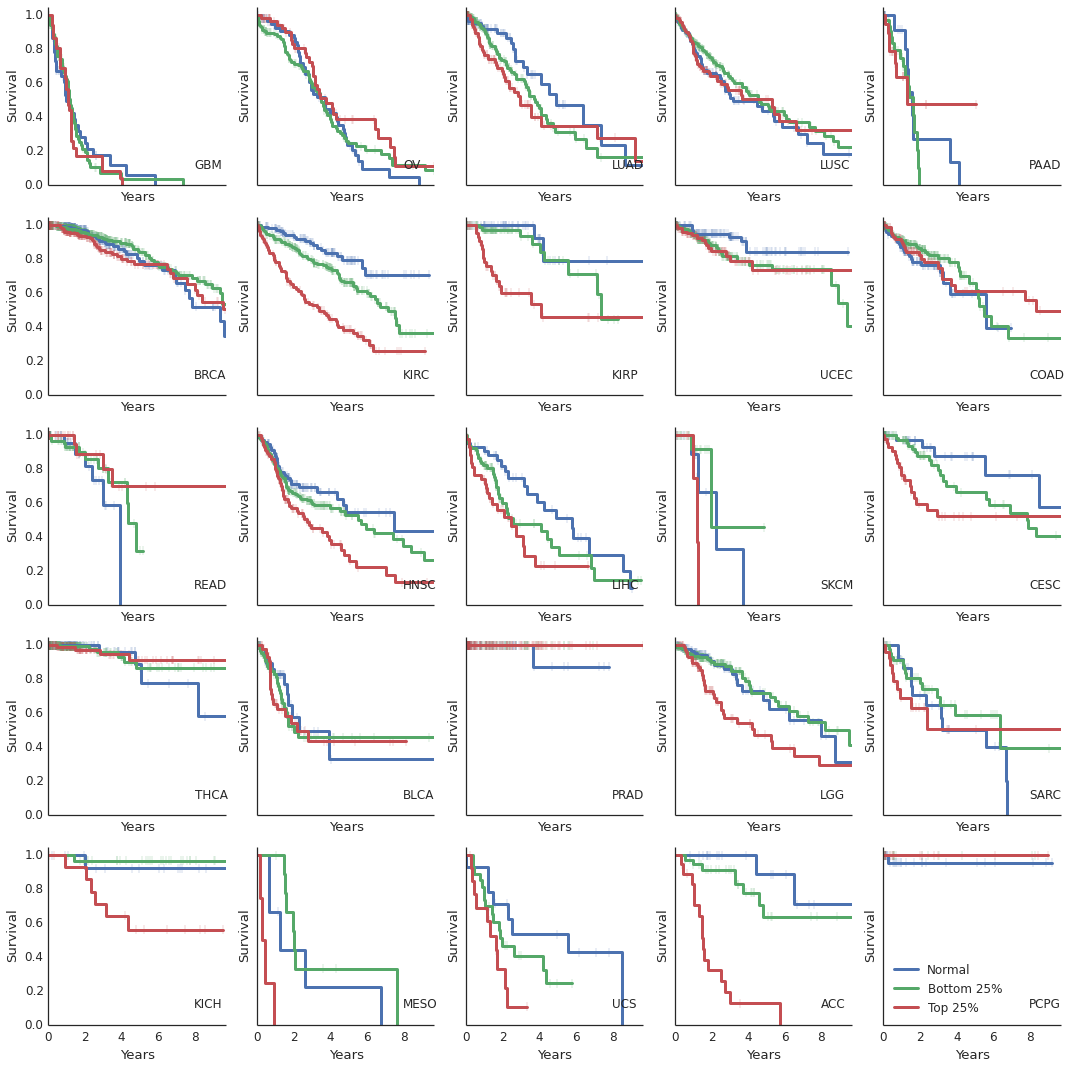

In [34]:
cc = codes.ix[v.index].dropna()
ss = surv_10y.unstack().index
cc = cc[cc.isin(ti(cc.value_counts()  > 30))]
fig, axs = subplots(5,5, figsize=(15,15), sharey=True, sharex=True)
axs = axs.flatten()
for i,c in enumerate(cc.unique()):
    ax = axs[i]
    ax.annotate(c, (8, .1))
    draw_survival_curve(v.ix[ss].ix[ti(cc==c)].dropna(), surv_10y,
                        ax=ax)
    ax.legend_.set_visible(False)
ax.legend_.set_visible(True)
fig.tight_layout()
DX.sns.despine(fig)